In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
import re

RANDOM_STATE = 11

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
sub.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


## 1. Data Exploration

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
train.nunique()

id          7613
keyword      221
location    3341
text        7503
target         2
dtype: int64

## 2. EDA

### Target

In [11]:
train['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

#### The target is a little imbalanced

### Keywords

In [14]:
train['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

#### Keyword looks like a useful feature bc includes a lot of words about disaster. Let's look closer

In [16]:
train['keyword'] = train['keyword'].fillna('Unknown')
test['keyword'] = test['keyword'].fillna('Unknown')

top_keywords = train['keyword'].value_counts().index[:10]
top_keywords

Index(['Unknown', 'fatalities', 'deluge', 'armageddon', 'sinking', 'damage',
       'harm', 'body%20bags', 'evacuate', 'fear'],
      dtype='object', name='keyword')

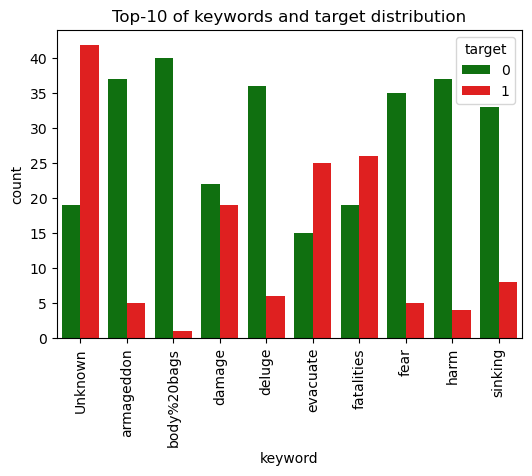

In [17]:
train_top_keywords = train[train['keyword'].isin(top_keywords)]

palette = {0: 'green', 1: 'red'}

plt.figure(figsize=(6, 4))
sns.countplot(data=train_top_keywords, x='keyword', hue='target', palette = palette)
plt.xticks(rotation=90)
plt.title('Top-10 of keywords and target distribution')
plt.show()

#### As we can see words that looks like a disaster are often used for non-disaster tweets. So it's not as easy as looks.
#### Let's look top-10 disaster and non-disaster keywords.

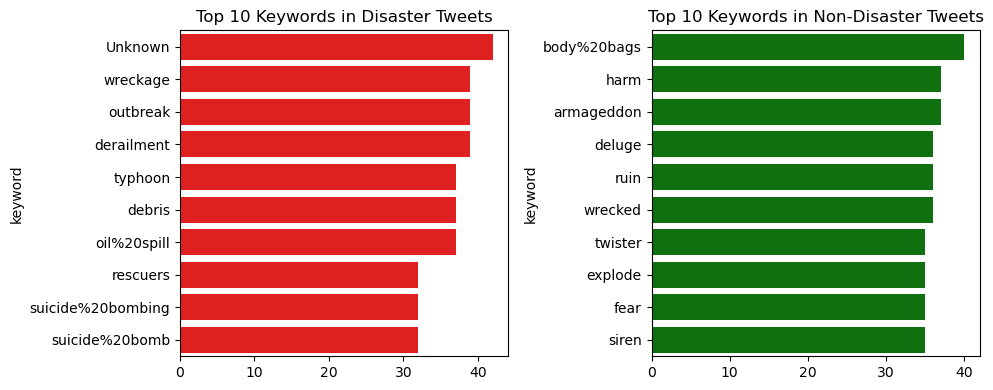

In [19]:
top_disaster_keywords = train[train['target'] == 1]['keyword'].value_counts().head(10)
top_nondisaster_keywords = train[train['target'] == 0]['keyword'].value_counts().head(10)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.barplot(y=top_disaster_keywords.index, x=top_disaster_keywords.values, ax=axes[0], color = 'red')
axes[0].set_title('Top 10 Keywords in Disaster Tweets')
sns.barplot(y=top_nondisaster_keywords.index, x=top_nondisaster_keywords.values, ax=axes[1], color = 'green')
axes[1].set_title('Top 10 Keywords in Non-Disaster Tweets')
plt.tight_layout()
plt.show()

#### We have different words in each of top-10 that's mean keywords are useful in some way

### Location

In [22]:
train['location'].unique()

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

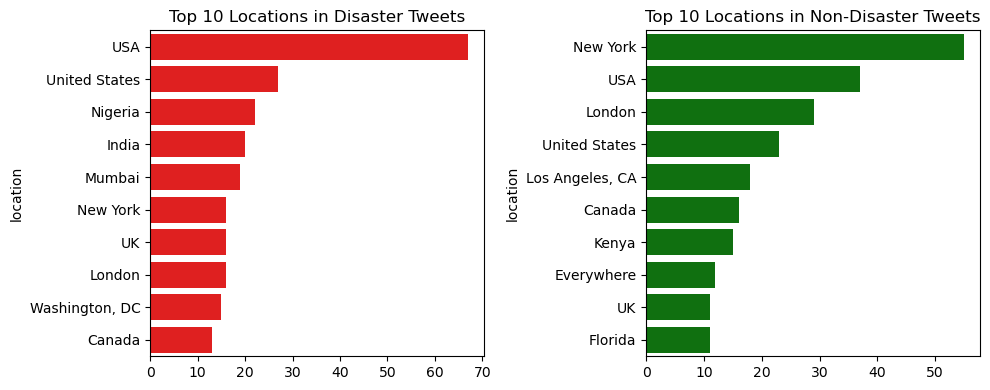

In [23]:
train['location'] = train['location'].fillna('Unknown')

top_disaster_locations = train[train['target'] == 1]['location'].value_counts().iloc[1:11]
top_nondisaster_locations = train[train['target'] == 0]['location'].value_counts().iloc[1:11]

# Plotting the top locations
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.barplot(y=top_disaster_locations.index, x=top_disaster_locations.values, ax=axes[0], color='red')
axes[0].set_title('Top 10 Locations in Disaster Tweets')
sns.barplot(y=top_nondisaster_locations.index, x=top_nondisaster_locations.values, ax=axes[1], color='green')
axes[1].set_title('Top 10 Locations in Non-Disaster Tweets')
plt.tight_layout()
plt.show()

#### Locations are not as useful as keywords. I guess we can drop it.

In [25]:
train.drop(columns=['id', 'location'], inplace=True, axis=1)
test.drop(columns=['location'], inplace=True)

train.head(2)

,keyword,text,target
0,Unknown,Our Deeds are the Reason of this #earthquake M...,1
1,Unknown,Forest fire near La Ronge Sask. Canada,1


In [26]:
train.isna().sum()

keyword    0
text       0
target     0
dtype: int64

In [27]:
test.isna().sum()

id         0
keyword    0
text       0
dtype: int64

## 3. Feature Engeneering

### Hashtags and mentions

In [30]:
train.iloc[0]

keyword                                              Unknown
text       Our Deeds are the Reason of this #earthquake M...
target                                                     1
Name: 0, dtype: object

#### Let's extract hashtags and mentions from text and then look how they impact on target distribution

In [32]:
train['hashtags'] = train['text'].apply(lambda x: re.findall(r'#\w+', x)).astype(str)
train['mentions'] = train['text'].apply(lambda x: re.findall(r'@\w+', x)).astype(str)

train.iloc[0]

keyword                                               Unknown
text        Our Deeds are the Reason of this #earthquake M...
target                                                      1
hashtags                                      ['#earthquake']
mentions                                                   []
Name: 0, dtype: object

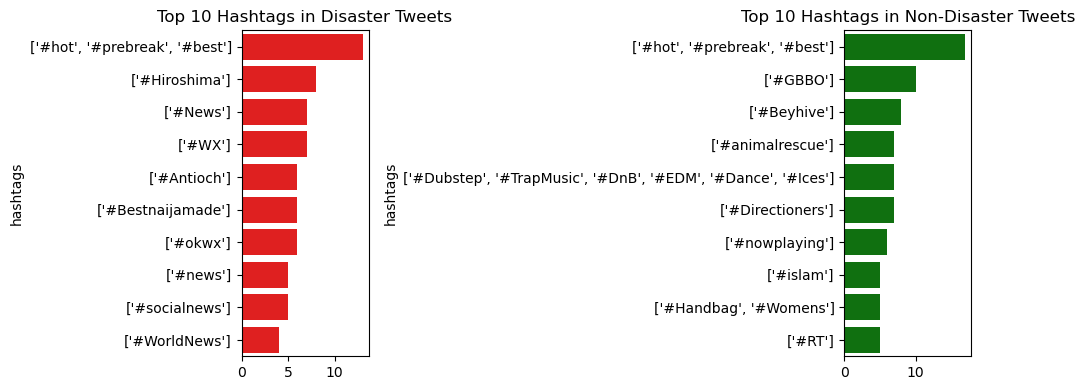

In [33]:
top_disaster_hashtags = train[train['target'] == 1]['hashtags'].value_counts().iloc[1:11]
top_nondisaster_hashtags = train[train['target'] == 0]['hashtags'].value_counts().iloc[1:11]

# Plotting the top locations
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.barplot(y=top_disaster_hashtags.index, x=top_disaster_hashtags.values, ax=axes[0], color='red')
axes[0].set_title('Top 10 Hashtags in Disaster Tweets')
sns.barplot(y=top_nondisaster_hashtags.index, x=top_nondisaster_hashtags.values, ax=axes[1], color='green')
axes[1].set_title('Top 10 Hashtags in Non-Disaster Tweets')
plt.tight_layout()
plt.show()

#### OK, maybe we can try use it for our purpose

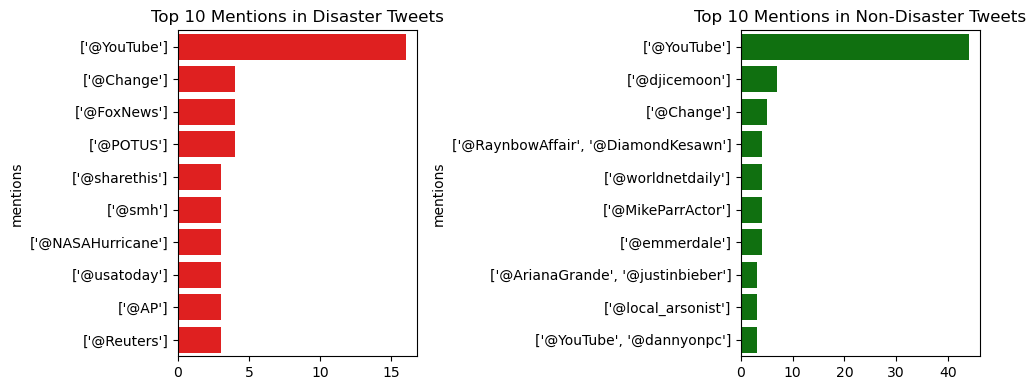

In [35]:
top_disaster_mentions = train[train['target'] == 1]['mentions'].value_counts().iloc[1:11]
top_nondisaster_mentions = train[train['target'] == 0]['mentions'].value_counts().iloc[1:11]

# Plotting the top locations
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.barplot(y=top_disaster_mentions.index, x=top_disaster_mentions.values, ax=axes[0], color='red')
axes[0].set_title('Top 10 Mentions in Disaster Tweets')
sns.barplot(y=top_nondisaster_mentions.index, x=top_nondisaster_mentions.values, ax=axes[1], color='green')
axes[1].set_title('Top 10 Mentions in Non-Disaster Tweets')
plt.tight_layout()
plt.show()

#### Top-3 has the same words in disaster and non-disaster tweets. It doesn't look like useful feature for us.

In [37]:
train.drop(columns=['mentions'], inplace=True, axis=1)

In [38]:
test['hashtags'] = test['text'].apply(lambda x: re.findall(r'#\w+', x)).astype(str)

### Bigrams

In [40]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(corpus, ngram_range=(2, 2), n=None):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get top bigrams
disaster_bigrams = get_top_ngrams(train[train['target'] == 1]['text'], ngram_range=(2, 2), n=10)
nondisaster_bigrams = get_top_ngrams(train[train['target'] == 0]['text'], ngram_range=(2, 2), n=10)

print("Top Bigrams in Disaster Tweets:", disaster_bigrams, '\n')
print("Top Bigrams in Non-Disaster Tweets:", nondisaster_bigrams)

Top Bigrams in Disaster Tweets: [('û_ http', 109), ('suicide bomber', 59), ('northern california', 41), ('oil spill', 38), ('burning buildings', 37), ('suicide bombing', 35), ('california wildfire', 34), ('70 years', 30), ('bomber detonated', 30), ('confirmed mh370', 29)] 

Top Bigrams in Non-Disaster Tweets: [('û_ http', 108), ('cross body', 39), ('youtube video', 36), ('liked youtube', 35), ('video http', 27), ('body bag', 27), ('gt gt', 26), ('û_ https', 24), ('body bagging', 24), ('burning buildings', 23)]


### Length of tweets 

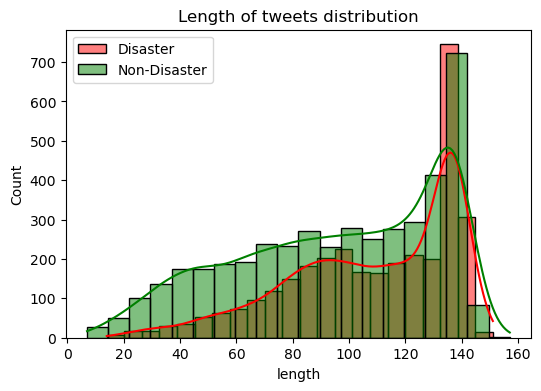

In [42]:
train["length"] = train["text"].apply(lambda x : len(x))
test["length"] = test["text"].apply(lambda x : len(x))

plt.figure(figsize=(6, 4))
sns.histplot(train[train['target'] == 1]['length'], color='red', label='Disaster', kde=True)
sns.histplot(train[train['target'] == 0]['length'], color='green', label='Non-Disaster', kde=True)
plt.title('Length of tweets distribution')
plt.legend()
plt.show()

#### We can see that fewer words indicate non-disaster tweets

In [44]:
train.head()

,keyword,text,target,hashtags,length
0,Unknown,Our Deeds are the Reason of this #earthquake M...,1,['#earthquake'],69
1,Unknown,Forest fire near La Ronge Sask. Canada,1,[],38
2,Unknown,All residents asked to 'shelter in place' are ...,1,[],133
3,Unknown,"13,000 people receive #wildfires evacuation or...",1,['#wildfires'],65
4,Unknown,Just got sent this photo from Ruby #Alaska as ...,1,"['#Alaska', '#wildfires']",88


## 4. Text Preprocessing 

#### Before modeling we should do the following preprocessing steps: Lowercase Conversion, URL Removal, Punctuation and Special Character Removal, Number Removal, Stopword Removal, Tokenization, and Lemmatization.

In [47]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\novoselya.pa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\novoselya.pa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [48]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercase text
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Remove punctuations and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenization and remove stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]
    # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

train['clean_text'] = train['text'].apply(preprocess_text)
test['clean_text'] = test['text'].apply(preprocess_text)

# Display a few examples to verify
print("Sample Preprocessed Text:")
print(train[['text', 'clean_text']].head(2))

Sample Preprocessed Text:
                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   

                                   clean_text  
0  deed reason earthquake may allah forgive u  
1       forest fire near la ronge sask canada  


### TF-IDF

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # Unigrams and bigrams
vectorizer = TfidfVectorizer()

target_train = train['target']

text_train = tfidf.fit_transform(train['clean_text'])
text_test = tfidf.transform(test['clean_text'])
print('Text train shape:', text_train.shape)

keyword_train = vectorizer.fit_transform(train['keyword'])
keyword_test = vectorizer.transform(test['keyword'])
print('Keyword train shape:', keyword_train.shape)

hashtags_train = vectorizer.fit_transform(train['hashtags'])
hashtags_test = vectorizer.transform(test['hashtags'])
print('Hashtags train shape:', hashtags_train.shape)

length_train = train['length'].values.reshape(-1, 1)
length_test = test['length'].values.reshape(-1, 1)
print('Length train shape:', length_train.shape)

Text train shape: (7613, 5000)
Keyword train shape: (7613, 240)
Hashtags train shape: (7613, 1917)
Length train shape: (7613, 1)


In [51]:
feature_train = hstack((text_train, keyword_train, hashtags_train, length_train))
feature_test = hstack((text_test, keyword_test, hashtags_test, length_test))
print('Feature train shape:', feature_train.shape)

X_train, X_val, y_train, y_val = train_test_split(feature_train, target_train, test_size=0.25, random_state=RANDOM_STATE)

Feature train shape: (7613, 7158)


## Model 1. LogisticRegression

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

model = LogisticRegression(max_iter=500, random_state=RANDOM_STATE)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Validation Accuracy: 0.81

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      1106
           1       0.84      0.68      0.75       798

    accuracy                           0.81      1904
   macro avg       0.82      0.79      0.80      1904
weighted avg       0.82      0.81      0.81      1904


Confusion Matrix:
[[1004  102]
 [ 256  542]]


#### Let's check the score if we delete some of features

In [55]:
feature_train = hstack((text_train, length_train))

X_train, X_val, y_train, y_val = train_test_split(feature_train, target_train, test_size=0.25, random_state=RANDOM_STATE)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Validation Accuracy: 0.81

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85      1106
           1       0.83      0.69      0.75       798

    accuracy                           0.81      1904
   macro avg       0.81      0.79      0.80      1904
weighted avg       0.81      0.81      0.81      1904


Confusion Matrix:
[[992 114]
 [249 549]]


In [59]:
X_train, X_val, y_train, y_val = train_test_split(text_train, target_train, test_size=0.25, random_state=RANDOM_STATE)

model.fit(X_train, y_train)

y_pred_lr = model.predict(X_val)

accuracy_lr = accuracy_score(y_val, y_pred)
f1_lr = f1_score(y_val, y_pred_lr)
print(f"Validation Accuracy: {accuracy_lr:.2f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# test_predictions = svm_model.predict(text_test)
# test['target'] = test_predictions

# submission = test[['id', 'target']]
# submission.to_csv('submission_lr.csv', index=False)

Validation Accuracy: 0.81

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      1106
           1       0.84      0.68      0.75       798

    accuracy                           0.81      1904
   macro avg       0.82      0.79      0.80      1904
weighted avg       0.82      0.81      0.81      1904


Confusion Matrix:
[[1004  102]
 [ 256  542]]


#### After several iteration the better score was only using text.

## Model 2. Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

rf_model = RandomForestClassifier(random_state=RANDOM_STATE)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_val)

accuracy_rf = accuracy_score(y_val, y_pred_rf)
f1_rf = f1_score(y_val, y_pred_rf)
print(f"Validation Accuracy (Random Forest): {accuracy_rf:.2f}")

print("\nClassification Report (Random Forest):")
print(classification_report(y_val, y_pred_rf))

print("\nConfusion Matrix (Random Forest):")
print(confusion_matrix(y_val, y_pred_rf))

Validation Accuracy (Random Forest): 0.80

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1106
           1       0.80      0.69      0.74       798

    accuracy                           0.80      1904
   macro avg       0.80      0.78      0.79      1904
weighted avg       0.80      0.80      0.80      1904


Confusion Matrix (Random Forest):
[[967 139]
 [246 552]]


## Model 3. XGBoost

In [65]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

xgb_model = XGBClassifier(random_state=RANDOM_STATE)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_val)

accuracy_xgb = accuracy_score(y_val, y_pred_xgb)
f1_xgb = f1_score(y_val, y_pred_xgb)
print(f"Validation Accuracy (XGBoost): {accuracy_xgb:.2f}")

print("\nClassification Report (XGBoost):")
print(classification_report(y_val, y_pred_xgb))

print("\nConfusion Matrix (XGBoost):")
print(confusion_matrix(y_val, y_pred_xgb))

Validation Accuracy (XGBoost): 0.78

Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.77      0.89      0.82      1106
           1       0.81      0.62      0.70       798

    accuracy                           0.78      1904
   macro avg       0.79      0.76      0.76      1904
weighted avg       0.78      0.78      0.77      1904


Confusion Matrix (XGBoost):
[[987 119]
 [301 497]]


## Model 4. SVM

In [67]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize and train the model
svm_model = SVC(random_state=RANDOM_STATE)
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_val)

# Evaluation
accuracy_svm = accuracy_score(y_val, y_pred_svm)
f1_svm = f1_score(y_val, y_pred_svm)
print(f"Validation Accuracy (SVM): {accuracy_svm:.2f}")

print("\nClassification Report (SVM):")
print(classification_report(y_val, y_pred_svm))

print("\nConfusion Matrix (SVM):")
print(confusion_matrix(y_val, y_pred_svm))

# test_predictions = svm_model.predict(text_test)
# test['target'] = test_predictions

# submission = test[['id', 'target']]
# submission.to_csv('submission_svm.csv', index=False)

Validation Accuracy (SVM): 0.81

Classification Report (SVM):
              precision    recall  f1-score   support

           0       0.79      0.92      0.85      1106
           1       0.85      0.67      0.75       798

    accuracy                           0.81      1904
   macro avg       0.82      0.79      0.80      1904
weighted avg       0.82      0.81      0.81      1904


Confusion Matrix (SVM):
[[1014   92]
 [ 263  535]]


In [68]:
print(f"Validation Accuracy (LR): {accuracy_lr:.2f}")
print(f"Validation Accuracy (RF): {accuracy_rf:.2f}")
print(f"Validation Accuracy (XGB): {accuracy_xgb:.2f}")
print(f"Validation Accuracy (SVM): {accuracy_svm:.2f}")

Validation Accuracy (LR): 0.81
Validation Accuracy (RF): 0.80
Validation Accuracy (XGB): 0.78
Validation Accuracy (SVM): 0.81


In [69]:
print(f"F1-score (LR): {f1_lr:.2f}")
print(f"F1-scorey (RF): {f1_rf:.2f}")
print(f"F1-score (XGB): {f1_xgb:.2f}")
print(f"F1-score (SVM): {f1_svm:.2f}")

F1-score (LR): 0.75
F1-scorey (RF): 0.74
F1-score (XGB): 0.70
F1-score (SVM): 0.75


#### Submission trough LR and SVM shows the same score result. Let's try one more way of modeling with RNN LSTM.

## Model 5. RNN LSTM

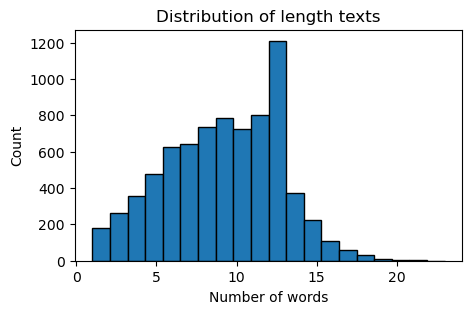

In [137]:
text_lengths = train['clean_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(5, 3))
plt.hist(text_lengths, bins=20, edgecolor='black')
plt.title("Distribution of length texts")
plt.xlabel("Number of words")
plt.ylabel("Count")
plt.show()

In [154]:
max_length = 15
coverage = (text_lengths <= max_length).mean() * 100
print(f"Percentage of texts covered by max length: {coverage:.2f}%")

Percentage of texts covered by max length: 97.25%


#### We can use max length = 15 for padding

In [156]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(train['clean_text'])

vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary Size: {vocab_size}")

train_sequences = tokenizer.texts_to_sequences(train['clean_text'])
test_sequences = tokenizer.texts_to_sequences(test['clean_text'])

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

print(f"Shape of train_padded: {train_padded.shape}")
print(f"Shape of test_padded: {test_padded.shape}")

Vocabulary Size: 15471
Shape of train_padded: (7613, 15)
Shape of test_padded: (3263, 15)


In [158]:
train_labels = np.array(train['target'])

In [166]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.build(input_shape=(None, max_length))
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 15, 64)         │       990,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,025,281 (3.91 MB)

 Trainable params: 1,025,281 (3.91 MB)

 Non-trainable params: 0 (0.00 B)

In [172]:
history = model.fit(
    train_padded, train_labels, 
    epochs=5, 
    batch_size=32, 
    validation_split=0.25)

Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9685 - loss: 0.0758 - val_accuracy: 0.7143 - val_loss: 1.1725
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9757 - loss: 0.0546 - val_accuracy: 0.7180 - val_loss: 1.4482
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9777 - loss: 0.0512 - val_accuracy: 0.7111 - val_loss: 1.2115
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9807 - loss: 0.0461 - val_accuracy: 0.6980 - val_loss: 1.3445
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9798 - loss: 0.0444 - val_accuracy: 0.7169 - val_loss: 1.2375


In [174]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint 

early_stopping = EarlyStopping(
    monitor='val_loss',      # Track validation loss
    patience=4,              # Stop after 4 epochs without improvement
    restore_best_weights=True  # Restore weights from the best epoch
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      # Track validation loss
    factor=0.5,              # Reduce learning rate by half
    patience=3,              # After 3 epochs without improvement
    min_lr=1e-6              # Minimum learning rate limit
)

model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras', # Save path
    monitor='val_loss',       # Track validation loss
    save_best_only=True       # Save only the best model
)

In [182]:
import tensorflow
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [184]:
history = model.fit(
    train_padded,train_labels,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9628 - loss: 0.1151 - val_accuracy: 0.7354 - val_loss: 0.7269 - learning_rate: 0.0010
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9753 - loss: 0.0619 - val_accuracy: 0.7282 - val_loss: 1.1470 - learning_rate: 0.0010
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9828 - loss: 0.0430 - val_accuracy: 0.7118 - val_loss: 1.1532 - learning_rate: 0.0010
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9779 - loss: 0.0476 - val_accuracy: 0.7157 - val_loss: 1.3207 - learning_rate: 0.0010
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9809 - loss: 0.0379 - val_accuracy: 0.7216 - val_loss: 1.2274 - learning_rate: 5.0000e-04


In [188]:
from tensorflow.keras.models import load_model

best_model = load_model('best_model.keras')

test_pred = best_model.predict(test_padded)

test_pred_labels = (test_pred > 0.5).astype(int).flatten()

print(f"Predictions: {test_pred_labels}")

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Predictions: [0 0 1 ... 1 1 1]


In [190]:
submission = pd.DataFrame({
    'id': test['id'],         # Replace 'id' with your ID column name if different
    'target': test_pred_labels  # Replace 'target' if a different name is required
})

print(submission.head())

   id  target
0   0       0
1   2       0
2   3       1
3   9       1
4  11       1


In [192]:
submission.to_csv('submission_LSTM.csv', index=False)

####